<a href="https://colab.research.google.com/github/tijazz/Big-Data/blob/main/SparkNotebooks/clusteranalysis_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setting up PySpark in Colab
Spark is written in the Scala programming language and requires the Java Virtual Machine (JVM) to run. Therefore, our first task is to download Java.



In [8]:
!apt-get install openjdk-8-jdk-headless

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-8-jdk-headless is already the newest version (8u312-b07-0ubuntu1~18.04).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 67 not upgraded.


Next, we will install Apache Spark 3.0.1 with Hadoop 2.7 .
Now, we just need to unzip that folder.

In [9]:

!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar xf /content/spark-3.2.1-bin-hadoop2.7.tgz


--2022-05-17 19:43:24--  https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272637746 (260M) [application/x-gzip]
Saving to: ‘spark-3.2.1-bin-hadoop2.7.tgz’

spark-3.2.1-bin-had 100%[===================>] 260.01M  19.3MB/s    in 14s     

2022-05-17 19:43:39 (18.1 MB/s) - ‘spark-3.2.1-bin-hadoop2.7.tgz’ saved [272637746/272637746]



There is one last thing that we need to install and that is the findspark library. It will locate Spark on the system and import it as a regular library.



In [10]:
!pip install -q findspark


Now that we have installed all the necessary dependencies in Colab, it is time to set the environment path. This will enable us to run Pyspark in the Colab environment.


In [11]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"


We need to locate Spark in the system. For that, we import findspark and use the findspark.init() method.

In [12]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.2.1-bin-hadoop2.7'

Now, we can import SparkSession from pyspark.sql and create a SparkSession, which is the entry point to Spark.

You can give a name to the session using appName() and add some configurations with config() if you wish.

In [14]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Clustering Analysis")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

Finally, print the SparkSession variable.

In [15]:
spark


#optional
If you want to view the Spark UI, you would have to include a few more lines of code to create a public URL for the UI page.

In [16]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels

--2022-05-17 19:44:15--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.237.133.81, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  19.4MB/s    in 0.7s    

2022-05-17 19:44:16 (19.4 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
{"tunnels":[],"uri":"/api/tunnels"}


#Loading data into PySpark
We will use the read.csv module. The inferSchema parameter provided will enable Spark to automatically determine the data type for each column but it has to go over the data once. If you don’t want that to happen, then you can instead provide the schema explicitly in the schema parameter.


In [18]:

# Utility functions for Spark Cluster Analysis Hands-On
#
#
from itertools import cycle, islice
from math import sqrt
from numpy import array
from pandas.plotting import parallel_coordinates
from pyspark.ml.clustering import KMeans as KM
from pyspark.mllib.linalg import DenseVector
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def computeCost(featuresAndPrediction, model):
    allClusterCenters = [DenseVector(c) for c in model.clusterCenters()]
    arrayCollection   = featuresAndPrediction.rdd.map(array)

    def error(point, predictedCluster):
        center = allClusterCenters[predictedCluster]
        z      = point - center
        return sqrt((z*z).sum())
    
    return arrayCollection.map(lambda row: error(row[0], row[1])).reduce(lambda x, y: x + y)


def elbow(elbowset, clusters):
	wsseList = []	
	for k in clusters:
		print("Training for cluster size {} ".format(k))
		kmeans = KM(k = k, seed = 1)
		model = kmeans.fit(elbowset)
		transformed = model.transform(elbowset)
		featuresAndPrediction = transformed.select("features", "prediction")

		W = computeCost(featuresAndPrediction, model)
		print("......................WSSE = {} ".format(W))

		wsseList.append(W)
	return wsseList

def elbow_plot(wsseList, clusters):
	wsseDF = pd.DataFrame({'WSSE' : wsseList, 'k' : clusters })
	wsseDF.plot(y='WSSE', x='k', figsize=(15,10), grid=True, marker='o')

def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')

	# Zip with a column called 'prediction' (index)
	Z = [np.append(A, index) for index, A in enumerate(centers)]

	# Convert to pandas for plotting
	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P

def parallel_plot(data, P):
	my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(P)))
	plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
	parallel_coordinates(data, 'prediction', color = my_colors, marker='o')


In [20]:
#first downlad the file from this url (r-click then save as) :
#https://mailbcuac.sharepoint.com/:u:/s/CMP7203-BigDataManagement_GRP/EQzfZhLMgkxNkClacJCqrrwBRPkVwiYJalp9JQtI5tBnSQ?e=ybKi7a
# after that you can upload it to the colab
df = spark.read.csv("/content/minute_weather.csv", header=True, inferSchema=True)

The first argument specifies the URL to the daily_weather.csv file, the second argument specifies the spark-csv format, the third argument says the first line in daily_weather.csv is the header, and the fourth argument says to infer the data types.

In [22]:
df.count()

235530

In [24]:
filteredDF = df.filter((df.rowID % 10) == 0)
filteredDF.count()

23553

In [25]:
filteredDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,23553,117760.0,67993.09781146907,0,235520
hpwren_timestamp,23553,None,None,2011-09-10 00:00:49,2012-02-20 18:11:39
air_pressure,23553,917.9839043858473,3.3709643252374715,906.4,929.5
air_temp,23553,58.14164310278932,11.346096137211923,35.24,90.68
avg_wind_direction,23543,145.03720851208428,96.01857303001776,0.0,359.0
avg_wind_speed,23543,2.8501975109374253,2.0738798619151515,0.0,23.4
max_wind_direction,23543,148.29758314573334,91.58909567858569,0.0,359.0
max_wind_speed,23543,3.5050163530561154,2.4517233000381675,0.1,24.5
min_wind_direction,23543,148.81828993756105,101.51852115235788,0.0,359.0


In [26]:
filteredDF.filter(filteredDF.rain_accumulation == 0.0).count() 

23334

In [27]:
filteredDF.filter(filteredDF.rain_duration == 0.0).count() 

23203

In [28]:
workingDF = filteredDF.drop('rain_accumulation').drop('rain_duration').drop('hpwren_timestamp')

In [30]:
#viewing the RDD, after dropping the column
workingDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,23553,117760.0,67993.09781146907,0,235520
air_pressure,23553,917.9839043858473,3.3709643252374715,906.4,929.5
air_temp,23553,58.14164310278932,11.346096137211923,35.24,90.68
avg_wind_direction,23543,145.03720851208428,96.01857303001776,0.0,359.0
avg_wind_speed,23543,2.8501975109374253,2.0738798619151515,0.0,23.4
max_wind_direction,23543,148.29758314573334,91.58909567858569,0.0,359.0
max_wind_speed,23543,3.5050163530561154,2.4517233000381675,0.1,24.5
min_wind_direction,23543,148.81828993756105,101.51852115235788,0.0,359.0
min_wind_speed,23543,2.1811493862294635,1.7517135329405467,0.0,21.6


In [31]:
before = workingDF.count()
workingDF = workingDF.na.drop()
after = workingDF.count()
before - after

10

In [32]:
workingDF.columns

['rowID',
 'air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'min_wind_direction',
 'min_wind_speed',
 'relative_humidity']

In [33]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
featuresUsed = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(workingDF)

In [34]:
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

In [35]:
scaledData = scaledData.select("features", "rowID")

elbowset = scaledData.filter((scaledData.rowID % 3) == 0).select("features")
elbowset.persist()

DataFrame[features: vector]

In [36]:
clusters = range(2,31)

wsseList = elbow(elbowset, clusters)

Training for cluster size 2 
......................WSSE = 17054.96976041502 
Training for cluster size 3 
......................WSSE = 15121.535384894043 
Training for cluster size 4 
......................WSSE = 13922.787753313522 
Training for cluster size 5 
......................WSSE = 12722.835053406356 
Training for cluster size 6 
......................WSSE = 12164.098946452536 
Training for cluster size 7 
......................WSSE = 11785.639559102548 
Training for cluster size 8 
......................WSSE = 11391.581477145946 
Training for cluster size 9 
......................WSSE = 11338.98669575139 
Training for cluster size 10 
......................WSSE = 10802.91634221975 
Training for cluster size 11 
......................WSSE = 10413.679501639968 
Training for cluster size 12 
......................WSSE = 10127.266320907027 
Training for cluster size 13 
......................WSSE = 10053.056951028553 
Training for cluster size 14 
......................WSSE = 9904

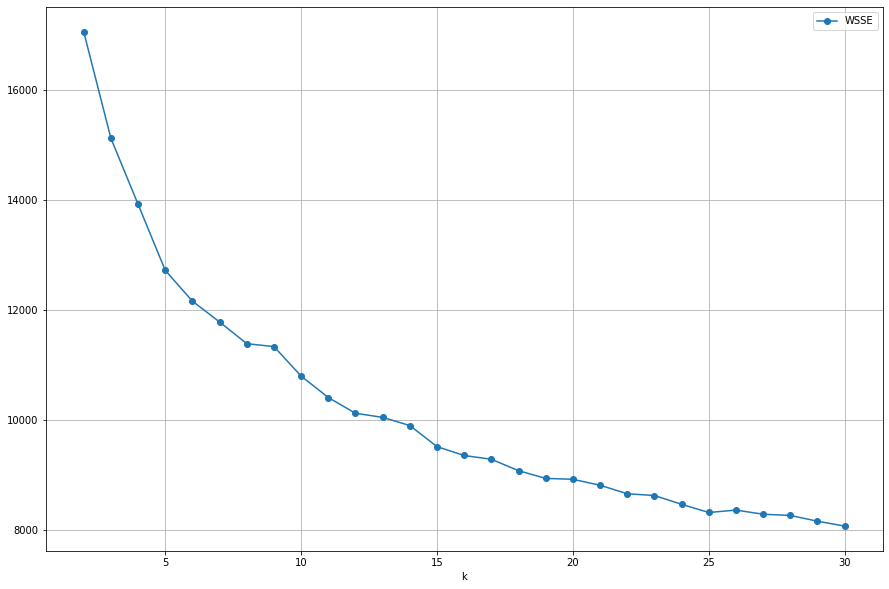

In [37]:
elbow_plot(wsseList, clusters)

In [38]:
scaledDataFeat = scaledData.select("features")
scaledDataFeat.persist()

DataFrame[features: vector]

In [39]:
kmeans = KMeans(k=12, seed=1)
model = kmeans.fit(scaledDataFeat)
transformed = model.transform(scaledDataFeat)

In [40]:
centers = model.clusterCenters()
centers

[array([ 0.06893804,  0.45683215,  1.60904112, -0.70362184,  1.90095478,
        -0.66528491, -0.40707692]),
 array([ 0.87387556, -0.30950457, -0.95975098,  2.17720105, -0.89984097,
         2.2486309 , -0.89228132]),
 array([-0.15708809, -0.06155095, -0.96357879,  0.65832553, -0.89730562,
         0.67199374, -0.56839844]),
 array([-0.54127266, -1.04557593,  0.69588235, -0.23285838,  0.70489923,
        -0.22992384,  1.44849906]),
 array([-0.31017723,  0.3576853 ,  0.5739888 ,  0.60899241,  0.60559511,
         0.53382581, -0.12563852]),
 array([-1.16646272, -1.10653809,  0.50774242,  1.55614152,  0.59250294,
         1.53740282,  1.41580738]),
 array([ 1.55739374,  0.26224265, -0.96529835, -0.17838169, -0.84935931,
        -0.16724466, -0.92473552]),
 array([-0.15404971, -0.92867244, -1.04937166, -0.59424866, -0.89364665,
        -0.5956719 ,  0.90810645]),
 array([ 1.18960234, -0.0575922 ,  0.73444403, -0.67071999,  0.4394387 ,
        -0.66138155, -0.60991629]),
 array([-0.40178733

In [41]:
P = pd_centers(featuresUsed, centers)

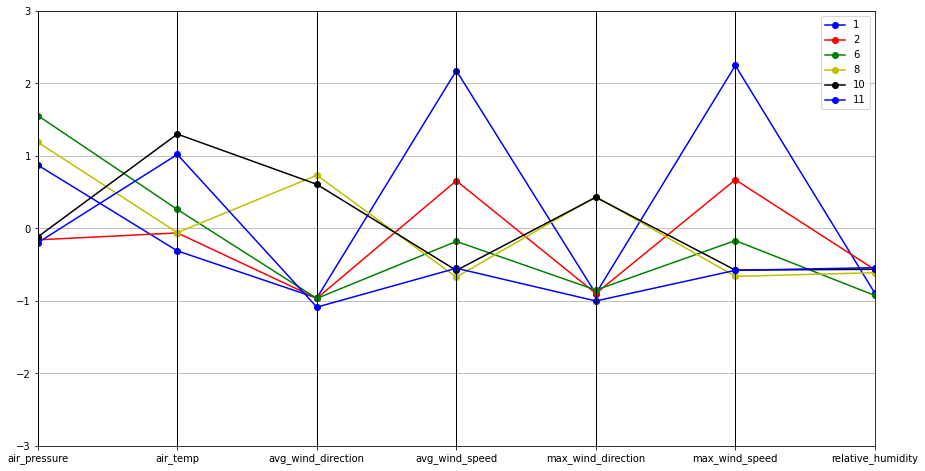

In [42]:
# Dry Days
parallel_plot(P[P['relative_humidity'] < -0.5], P)

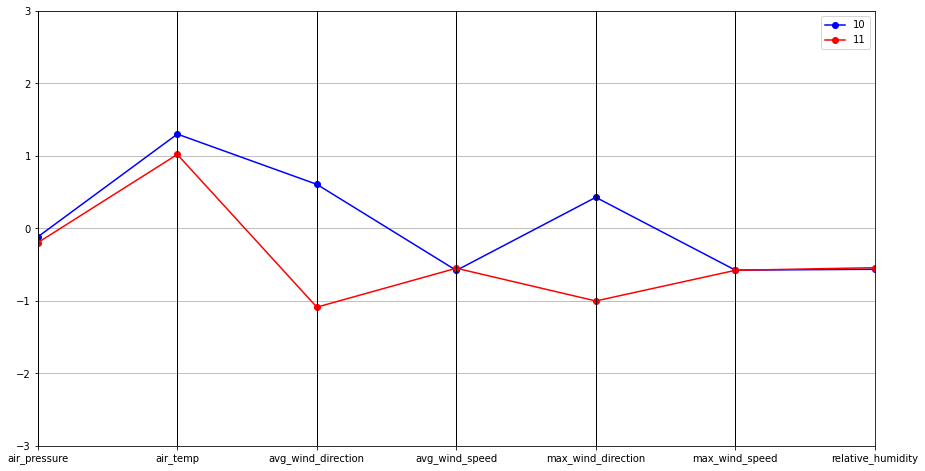

In [43]:
#warm days
parallel_plot(P[P['air_temp'] > 0.5], P)

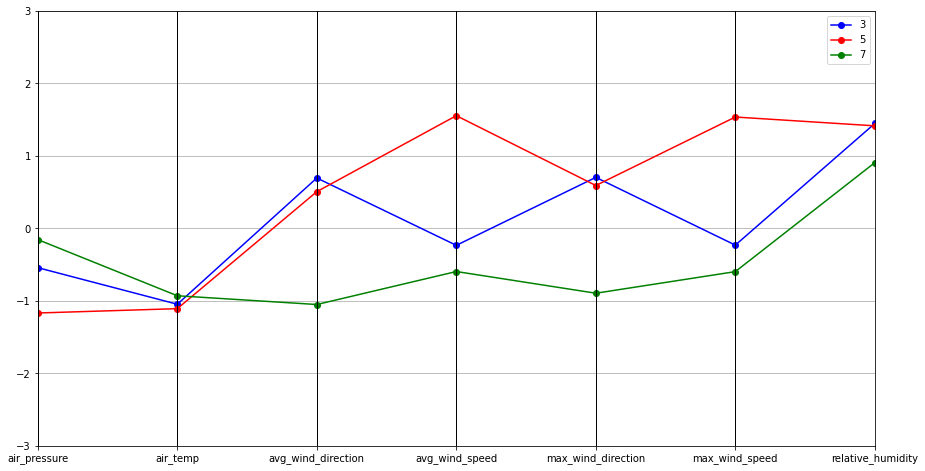

In [44]:
#cool days
parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)], P)

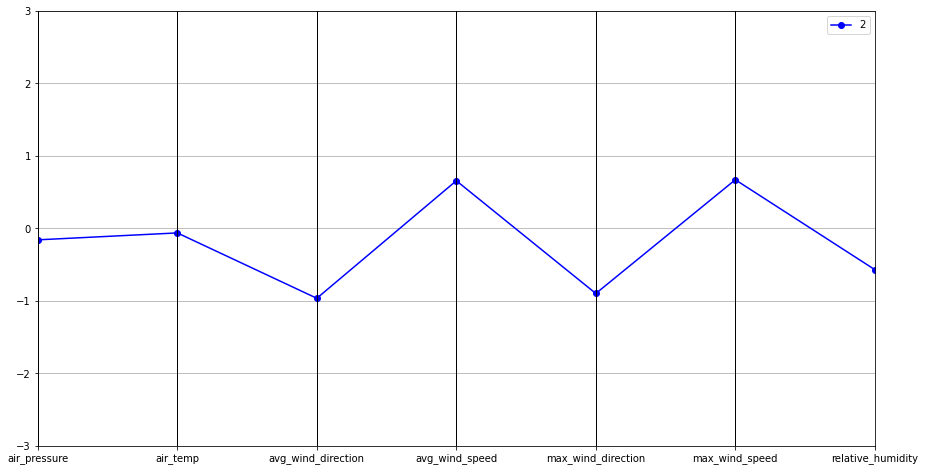

In [45]:
#other days
parallel_plot(P.iloc[[2]], P)